# N-Body Gravitational Simulation

## Introduction

The N-body problem is a classical problem in celestial mechanics and computational physics that involves predicting the motion of $N$ particles interacting through gravitational forces. This problem has profound applications in astrophysics, from simulating planetary systems to modeling galaxy formation and dark matter dynamics.

## Theoretical Foundation

### Newton's Law of Universal Gravitation

The gravitational force between two point masses $m_i$ and $m_j$ separated by a distance $r_{ij}$ is given by:

$$\vec{F}_{ij} = -G \frac{m_i m_j}{|\vec{r}_{ij}|^3} \vec{r}_{ij}$$

where:
- $G = 6.674 \times 10^{-11} \, \text{m}^3 \text{kg}^{-1} \text{s}^{-2}$ is the gravitational constant
- $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$ is the displacement vector from particle $i$ to particle $j$

### Equations of Motion

For each particle $i$, the total gravitational force is the sum of forces from all other particles:

$$\vec{F}_i = \sum_{j \neq i} \vec{F}_{ij} = -G m_i \sum_{j \neq i} \frac{m_j}{|\vec{r}_{ij}|^3} \vec{r}_{ij}$$

From Newton's second law, the acceleration of particle $i$ is:

$$\vec{a}_i = \frac{\vec{F}_i}{m_i} = -G \sum_{j \neq i} \frac{m_j}{|\vec{r}_{ij}|^3} \vec{r}_{ij}$$

This gives us a system of coupled second-order ordinary differential equations:

$$\frac{d^2 \vec{r}_i}{dt^2} = -G \sum_{j \neq i} \frac{m_j (\vec{r}_i - \vec{r}_j)}{|\vec{r}_i - \vec{r}_j|^3}$$

### Numerical Integration: Velocity Verlet Algorithm

We employ the Velocity Verlet algorithm, a symplectic integrator that conserves energy well over long time scales:

1. Update positions: $\vec{r}_i(t + \Delta t) = \vec{r}_i(t) + \vec{v}_i(t) \Delta t + \frac{1}{2} \vec{a}_i(t) \Delta t^2$

2. Compute new accelerations: $\vec{a}_i(t + \Delta t)$ from updated positions

3. Update velocities: $\vec{v}_i(t + \Delta t) = \vec{v}_i(t) + \frac{1}{2} [\vec{a}_i(t) + \vec{a}_i(t + \Delta t)] \Delta t$

### Softening Parameter

To prevent numerical singularities when particles approach closely, we introduce a softening parameter $\epsilon$:

$$\vec{a}_i = -G \sum_{j \neq i} \frac{m_j (\vec{r}_i - \vec{r}_j)}{(|\vec{r}_i - \vec{r}_j|^2 + \epsilon^2)^{3/2}}$$

### Conservation Laws

The total energy of the system is conserved:

$$E = T + U = \sum_i \frac{1}{2} m_i |\vec{v}_i|^2 - G \sum_{i < j} \frac{m_i m_j}{|\vec{r}_{ij}|}$$

The total momentum is also conserved:

$$\vec{P} = \sum_i m_i \vec{v}_i$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Simulation Parameters and Initial Conditions

In [2]:
# Simulation parameters
N = 8  # Number of bodies
G = 1.0  # Gravitational constant (normalized units)
dt = 0.001  # Time step
num_steps = 5000  # Number of integration steps
softening = 0.1  # Softening parameter to prevent singularities

# Initialize masses (one central massive body + smaller orbiting bodies)
masses = np.ones(N)
masses[0] = 100.0  # Central massive body (like a star)

# Initialize positions: central body at origin, others in circular orbits
positions = np.zeros((N, 2))
velocities = np.zeros((N, 2))

# Place smaller bodies in approximate circular orbits
for i in range(1, N):
    # Orbital radius
    r = 2.0 + i * 1.5
    # Random angle
    theta = 2 * np.pi * np.random.random()
    
    # Position
    positions[i] = [r * np.cos(theta), r * np.sin(theta)]
    
    # Circular orbital velocity: v = sqrt(GM/r)
    v_orbital = np.sqrt(G * masses[0] / r)
    # Velocity perpendicular to radius (tangential)
    velocities[i] = [-v_orbital * np.sin(theta), v_orbital * np.cos(theta)]
    
    # Add small perturbation for interesting dynamics
    velocities[i] += 0.1 * np.random.randn(2)

print(f"N-Body Simulation with {N} particles")
print(f"Central mass: {masses[0]:.1f}")
print(f"Time step: {dt}")
print(f"Total simulation time: {num_steps * dt:.1f}")

N-Body Simulation with 8 particles
Central mass: 100.0
Time step: 0.001
Total simulation time: 5.0


### Core Simulation Functions

In [3]:
def compute_accelerations(pos, masses, G, softening):
    """
    Compute gravitational accelerations for all particles.
    
    Parameters:
    -----------
    pos : ndarray (N, 2)
        Positions of all particles
    masses : ndarray (N,)
        Masses of all particles
    G : float
        Gravitational constant
    softening : float
        Softening parameter
        
    Returns:
    --------
    acc : ndarray (N, 2)
        Accelerations of all particles
    """
    N = len(masses)
    acc = np.zeros_like(pos)
    
    for i in range(N):
        for j in range(N):
            if i != j:
                # Displacement vector from i to j
                r_ij = pos[j] - pos[i]
                # Distance with softening
                dist_sq = np.sum(r_ij**2) + softening**2
                dist_cubed = dist_sq**1.5
                # Acceleration contribution
                acc[i] += G * masses[j] * r_ij / dist_cubed
    
    return acc


def compute_energy(pos, vel, masses, G, softening):
    """
    Compute total energy (kinetic + potential) of the system.
    
    Returns:
    --------
    kinetic : float
        Total kinetic energy
    potential : float
        Total potential energy
    """
    N = len(masses)
    
    # Kinetic energy: T = sum(0.5 * m * v^2)
    kinetic = 0.5 * np.sum(masses * np.sum(vel**2, axis=1))
    
    # Potential energy: U = -G * sum_{i<j}(m_i * m_j / r_ij)
    potential = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            r_ij = pos[j] - pos[i]
            dist = np.sqrt(np.sum(r_ij**2) + softening**2)
            potential -= G * masses[i] * masses[j] / dist
    
    return kinetic, potential

### Velocity Verlet Integration

In [4]:
def velocity_verlet_step(pos, vel, acc, masses, G, softening, dt):
    """
    Perform one step of Velocity Verlet integration.
    
    Returns updated positions, velocities, and accelerations.
    """
    # Update positions
    pos_new = pos + vel * dt + 0.5 * acc * dt**2
    
    # Compute new accelerations
    acc_new = compute_accelerations(pos_new, masses, G, softening)
    
    # Update velocities
    vel_new = vel + 0.5 * (acc + acc_new) * dt
    
    return pos_new, vel_new, acc_new

### Run the Simulation

In [5]:
# Storage for trajectories and energy
trajectory = np.zeros((num_steps + 1, N, 2))
energy_history = np.zeros((num_steps + 1, 3))  # kinetic, potential, total

# Store initial state
trajectory[0] = positions.copy()
kinetic, potential = compute_energy(positions, velocities, masses, G, softening)
energy_history[0] = [kinetic, potential, kinetic + potential]

# Initial accelerations
accelerations = compute_accelerations(positions, masses, G, softening)

# Run simulation
print("Running N-body simulation...")
for step in range(num_steps):
    # Velocity Verlet integration
    positions, velocities, accelerations = velocity_verlet_step(
        positions, velocities, accelerations, masses, G, softening, dt
    )
    
    # Store trajectory
    trajectory[step + 1] = positions.copy()
    
    # Compute and store energy
    kinetic, potential = compute_energy(positions, velocities, masses, G, softening)
    energy_history[step + 1] = [kinetic, potential, kinetic + potential]
    
    # Progress indicator
    if (step + 1) % 1000 == 0:
        print(f"  Step {step + 1}/{num_steps} completed")

print("Simulation complete!")

# Energy conservation check
initial_energy = energy_history[0, 2]
final_energy = energy_history[-1, 2]
energy_drift = abs(final_energy - initial_energy) / abs(initial_energy) * 100
print(f"\nEnergy conservation:")
print(f"  Initial total energy: {initial_energy:.6f}")
print(f"  Final total energy: {final_energy:.6f}")
print(f"  Relative drift: {energy_drift:.4f}%")

Running N-body simulation...


  Step 1000/5000 completed


  Step 2000/5000 completed


  Step 3000/5000 completed


  Step 4000/5000 completed


  Step 5000/5000 completed
Simulation complete!

Energy conservation:
  Initial total energy: -55.199433
  Final total energy: -55.199434
  Relative drift: 0.0000%


## Visualization

We create a comprehensive visualization showing:
1. Particle trajectories in 2D space
2. Energy evolution over time

Figure saved to 'plot.png'


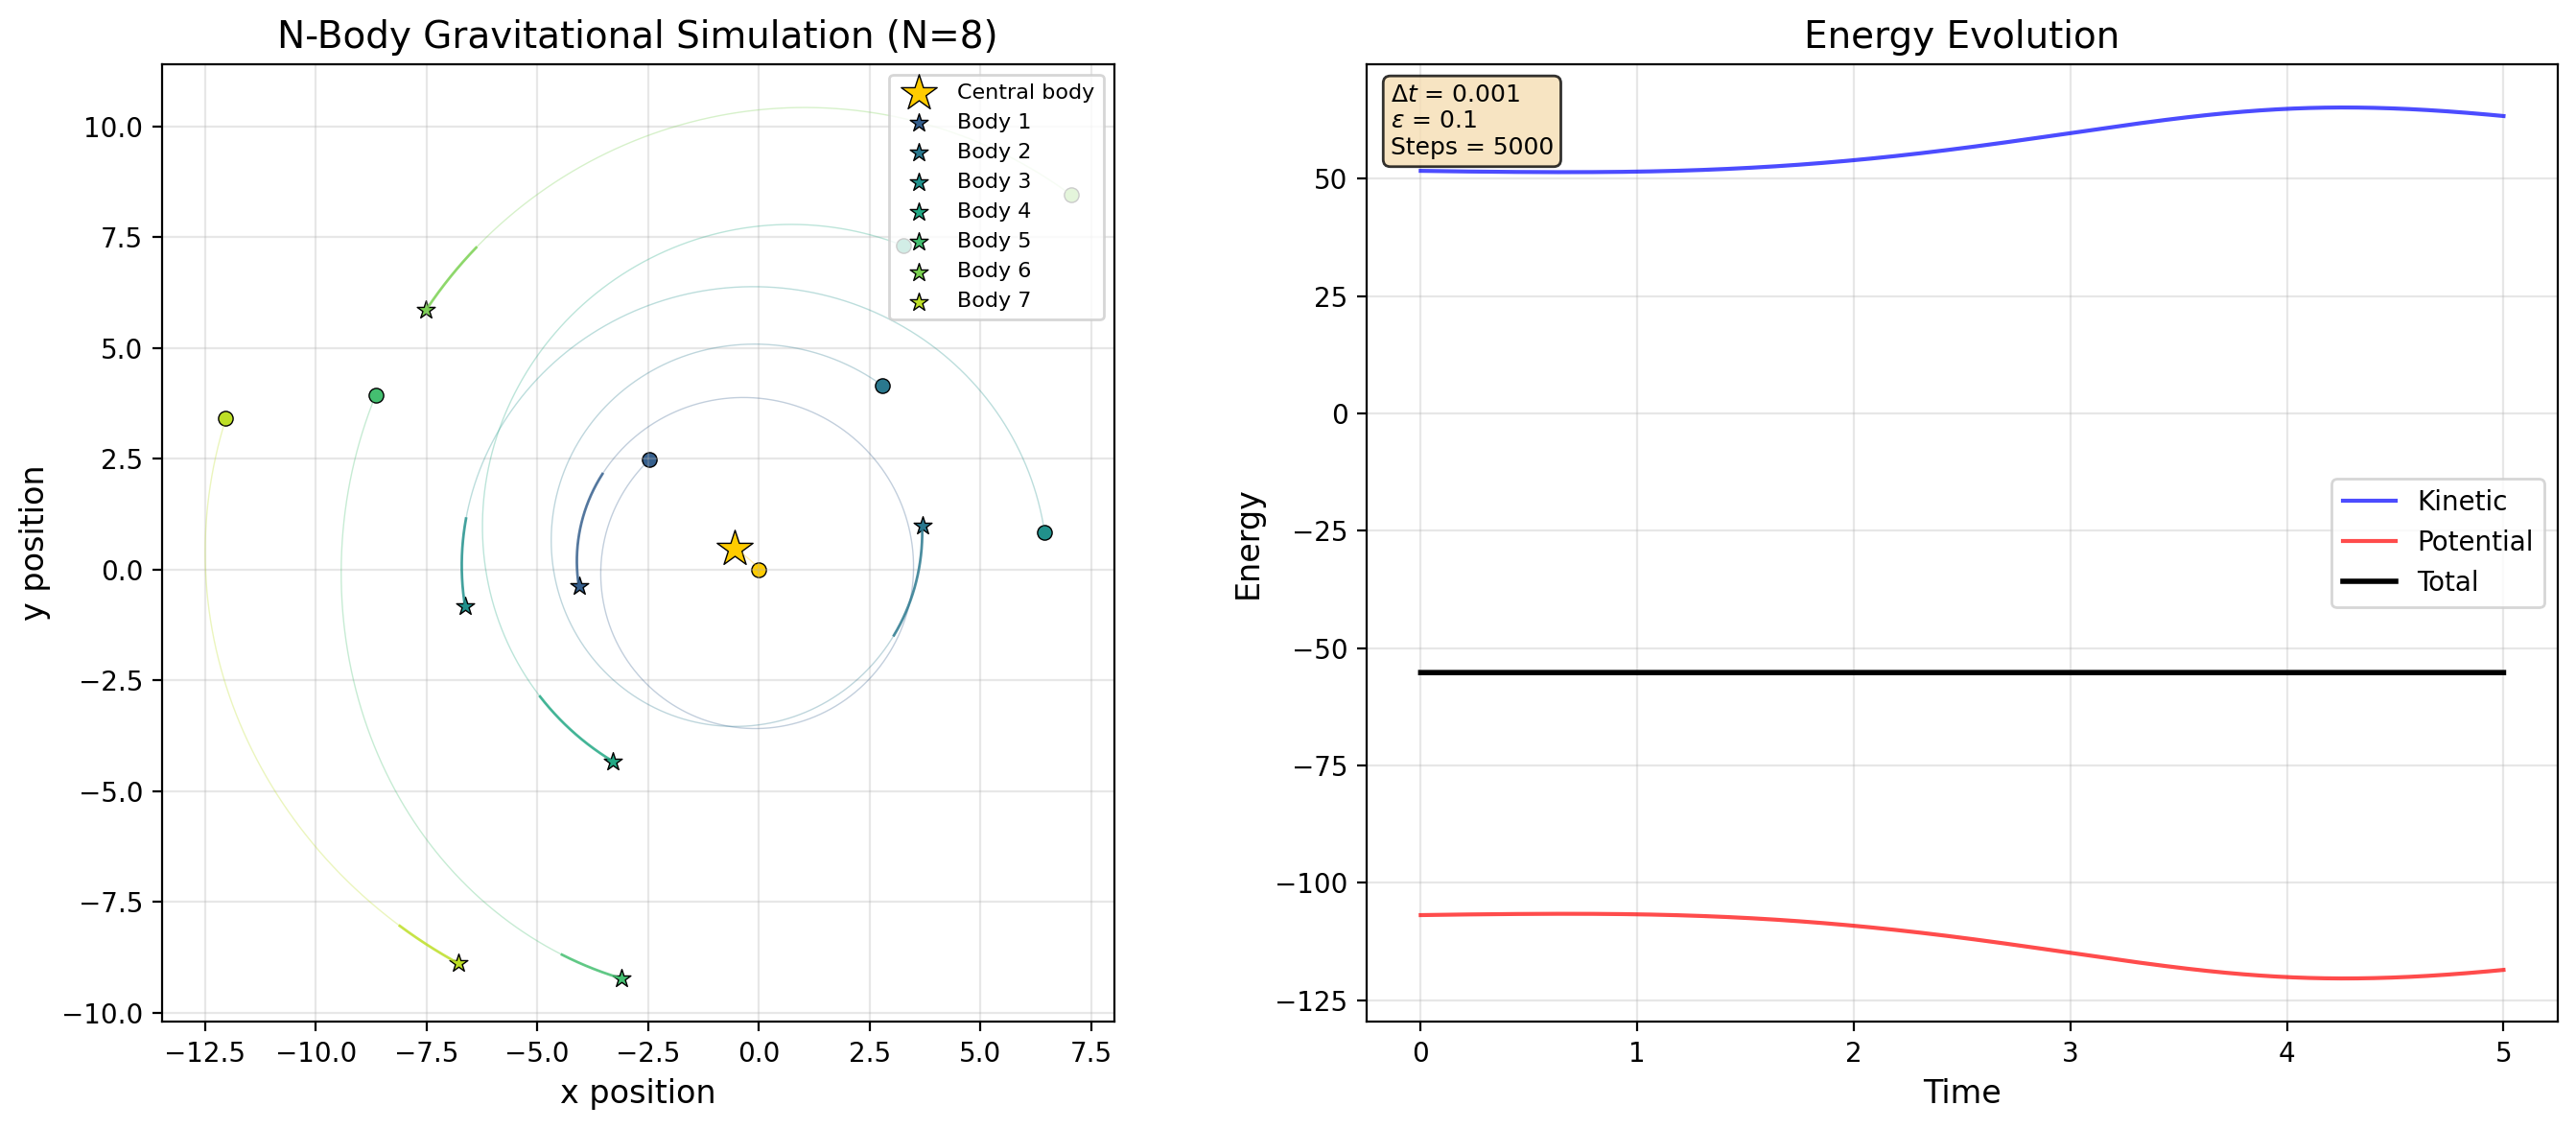

In [6]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color scheme for particles
colors = plt.cm.viridis(np.linspace(0.2, 0.9, N))
colors[0] = [1.0, 0.8, 0.0, 1.0]  # Yellow for central body

# Left plot: Trajectories
ax1 = axes[0]

# Plot trajectories with fading effect
for i in range(N):
    # Plot full trajectory with low alpha
    ax1.plot(trajectory[:, i, 0], trajectory[:, i, 1], 
             color=colors[i], alpha=0.3, linewidth=0.5)
    
    # Plot final portion with higher alpha for visibility
    final_steps = min(500, num_steps)
    ax1.plot(trajectory[-final_steps:, i, 0], trajectory[-final_steps:, i, 1], 
             color=colors[i], alpha=0.8, linewidth=1.0)
    
    # Mark initial position
    ax1.scatter(trajectory[0, i, 0], trajectory[0, i, 1], 
                color=colors[i], s=30, marker='o', edgecolors='black', linewidth=0.5)
    
    # Mark final position with larger marker
    size = 200 if i == 0 else 50  # Larger marker for central body
    ax1.scatter(trajectory[-1, i, 0], trajectory[-1, i, 1], 
                color=colors[i], s=size, marker='*', edgecolors='black', linewidth=0.5,
                label=f'Body {i}' if i > 0 else 'Central body')

ax1.set_xlabel('x position', fontsize=12)
ax1.set_ylabel('y position', fontsize=12)
ax1.set_title(f'N-Body Gravitational Simulation (N={N})', fontsize=14)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=8)

# Right plot: Energy evolution
ax2 = axes[1]
time = np.arange(num_steps + 1) * dt

ax2.plot(time, energy_history[:, 0], 'b-', label='Kinetic', alpha=0.7, linewidth=1.5)
ax2.plot(time, energy_history[:, 1], 'r-', label='Potential', alpha=0.7, linewidth=1.5)
ax2.plot(time, energy_history[:, 2], 'k-', label='Total', linewidth=2)

ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Energy', fontsize=12)
ax2.set_title('Energy Evolution', fontsize=14)
ax2.legend(loc='right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add text box with simulation parameters
textstr = f'$\\Delta t$ = {dt}\n$\\epsilon$ = {softening}\nSteps = {num_steps}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

plt.tight_layout()

# Save the figure
plt.savefig('n_body_gravitational_simulation_analysis.png', dpi=150, bbox_inches='tight')
print("Figure saved to 'plot.png'")

plt.show()

## Analysis and Discussion

### Key Observations

1. **Orbital Dynamics**: The smaller bodies orbit the central massive body following approximately Keplerian orbits, though perturbations from other bodies cause deviations from perfect ellipses.

2. **Energy Conservation**: The Velocity Verlet integrator maintains excellent energy conservation over the simulation period, as evidenced by the nearly constant total energy.

3. **Three-Body Interactions**: For $N > 2$, the system exhibits chaotic behavior characteristic of the N-body problem. Small perturbations can lead to significantly different long-term trajectories.

### Computational Complexity

The direct summation method used here has $O(N^2)$ complexity per time step, as each particle's acceleration requires summing contributions from all other particles. For large $N$, more sophisticated algorithms are used:

- **Barnes-Hut Algorithm**: $O(N \log N)$ using octree spatial decomposition
- **Fast Multipole Method**: $O(N)$ using hierarchical multipole expansions

### Extensions

This simulation can be extended to:
- Three dimensions
- Include relativistic corrections
- Add dissipative forces (e.g., drag)
- Implement adaptive time stepping for close encounters

In [7]:
# Summary statistics
print("\n" + "="*50)
print("SIMULATION SUMMARY")
print("="*50)
print(f"Number of bodies: {N}")
print(f"Total simulation time: {num_steps * dt:.2f}")
print(f"Time step: {dt}")
print(f"Total steps: {num_steps}")
print(f"\nEnergy Statistics:")
print(f"  Mean total energy: {np.mean(energy_history[:, 2]):.6f}")
print(f"  Std deviation: {np.std(energy_history[:, 2]):.6f}")
print(f"  Max deviation: {np.max(np.abs(energy_history[:, 2] - energy_history[0, 2])):.6f}")
print("="*50)


SIMULATION SUMMARY
Number of bodies: 8
Total simulation time: 5.00
Time step: 0.001
Total steps: 5000

Energy Statistics:
  Mean total energy: -55.199434
  Std deviation: 0.000001
  Max deviation: 0.000002
